In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

images, labels = images.to(device), labels.to(device)

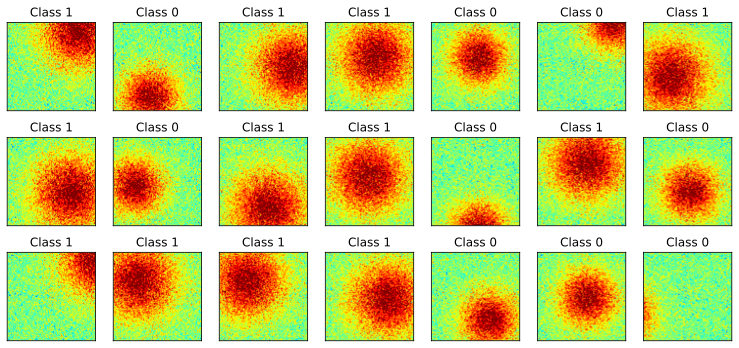

In [4]:
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  G = G.cpu()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [5]:
len(images)

2000

In [24]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size= 0.2, random_state = 42)

train_data = TensorDataset(train_data, train_label)
test_data = TensorDataset(test_data, test_label)

batch_size = 32
train_loader = DataLoader(train_data, shuffle = True, drop_last = True, batch_size = batch_size)
test_loader = DataLoader(test_data, drop_last = True, batch_size = test_data.tensors[0].shape[0])




In [25]:
print(train_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[0].shape)

torch.Size([1600, 1, 91, 91])
torch.Size([400, 1, 91, 91])


In [26]:
print(train_loader.dataset.tensors[1].shape)

torch.Size([1600, 1])


In [35]:
def makeTheNet():
  class GausNet(nn.Module):
    def __init__(self):
      super().__init__()

      self.enc = nn.Sequential(
          nn.Conv2d(1, 6, 3, padding = 1),
          nn.ReLU(),
          nn.AvgPool2d(2,2),
          nn.Conv2d(6, 4, 3, padding = 1),
          nn.ReLU(),
          nn.AvgPool2d(2, 2),
          nn.Flatten(),
          nn.Linear(22*22*4, 50),
          nn.Linear(50, 1)
      )



    def forward(self, x):
      x = self.enc(x)
      return x

  net = GausNet()
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

  return net, lossfun, optimizer

In [27]:
def makeTheNet():
  class GausNet(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(1, 6, 3, padding = 1)
      # output layer = np.floor((91 + 2*1 -3)/1) + 1 = 91
      # maxpool = 91/2 = 45

      self.conv2 = nn.Conv2d(6, 4, 3, padding = 1)
      # output size = np.floor((45 + 2*1 -3)/1) + 1 = 45
      # maxpool = 45/2 = 22

      self.fc1 = nn.Linear(22*22*4, 50)
      self.fc2 = nn.Linear(50, 1)
    

    def forward(self, x):
      conv1act = F.relu(self.conv1(x))
      x = F.avg_pool2d(conv1act, (2, 2))

      conv2act = F.relu(self.conv2(x))
      x = F.avg_pool2d(conv2act, (2, 2))

      x = x.reshape(x.shape[0], -1)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x, conv1act, conv2act

  net = GausNet()
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

  return net, lossfun, optimizer
  

In [ ]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      

      # soft-coded variables
      k = (3,2)
      s = (2,3)

      ### conv1
      self.conv1 = nn.Conv2d(1,3,k,s)
      
      # output of convolution layer (second line is for pooling layer)
      imsizeW = np.floor( (91+2*self.conv1.padding[0]-k[0])/s[0] ) + 1
      imsizeW = np.floor( imsizeW/2 )
      imsizeH = np.floor( (91+2*self.conv1.padding[1]-k[1])/s[1] ) + 1
      imsizeH = np.floor( imsizeH/2 )


      ### conv2
      self.conv2 = nn.Conv2d(3,6,k,s)
      
      # output of convolution layer (second line is for pooling layer)
      # notice that it requires the image size from the previous conv-pool layer
      imsizeW = np.floor( (imsizeW+2*self.conv1.padding[0]-k[0])/s[0] ) + 1
      imsizeW = int( imsizeW/2 ) # input to nn.Linear must be ints, and int() rounds down
      imsizeH = np.floor( (imsizeH+2*self.conv1.padding[1]-k[1])/s[1] ) + 1
      imsizeH = int( imsizeH/2 ) # input to nn.Linear must be ints, and int() rounds down

      
      # fc1 (soft-coded number of input units!)
      self.fc1 = nn.Linear(imsizeW*imsizeH*self.conv2.out_channels,50)

      # fc2 (output)
      self.fc2 = nn.Linear(50,1)
      
    def forward(self,x):
      # first conv-pool set
      conv1act = F.relu(self.conv1(x))
      x = F.avg_pool2d(conv1act,(2,2))
      
      # second conv-pool set
      conv2act = F.relu(self.conv2(x))
      x = F.avg_pool2d(conv2act,(2,2))

      # ANN part
      x = x.reshape(x.shape[0],-1)
      x = F.relu( self.fc1(x) )
      x = self.fc2(x)
      
      return x,conv1act,conv2act
  
  # create the model instance
  net = gausnet()
  
  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [20]:
net, lossfun, optimizer = makeTheNet()
net.cuda()
X, y = next(iter(train_loader))
yHat, featmap1, featmap2 = net(X)
loss = lossfun(yHat, y)
print(yHat.shape)
print('')
print(loss)
print('')
print(featmap1.shape)
print('')
print(featmap2.shape)

torch.Size([32, 1])

tensor(0.6935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

torch.Size([32, 6, 91, 91])

torch.Size([32, 4, 45, 45])


In [21]:
summary(net, (1, imgSize, imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 4, 45, 45]             220
            Linear-3                   [-1, 50]          96,850
            Linear-4                    [-1, 1]              51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [32]:
def function2trainTheModel():
  numepochs = 10
  net, lossfun, optimizer = makeTheNet()
  net.cuda()
  trainLoss = torch.zeros(numepochs)
  testLoss = torch.zeros(numepochs)
  trainAcc = torch.zeros(numepochs)
  testAcc = torch.zeros(numepochs)

  for epochi in range(numepochs):
    batchLoss = []
    batchAcc = []

    for X, y in train_loader:
      yHat = net(X)[0]
      loss = lossfun(yHat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      batchLoss.append(loss.item())
      batchAcc.append(torch.mean(((yHat>0) == y).float()).item())


    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = 100 * np.mean(batchAcc)


  X, y = next(iter(test_loader))
  with torch.no_grad():
    yHat = net(X)[0]
    loss = lossfun(yHat, y)
  
  print(loss)
  testLoss[epochi] = loss.item()
  testAcc[epochi] = 100 * torch.mean(((yHat> 0) == y).float()).item()

  return trainLoss, testLoss, trainAcc, testAcc, net

In [33]:
trainLoss, testLoss, trainAcc, testAcc, net = function2trainTheModel()

tensor(0.0620, device='cuda:0')


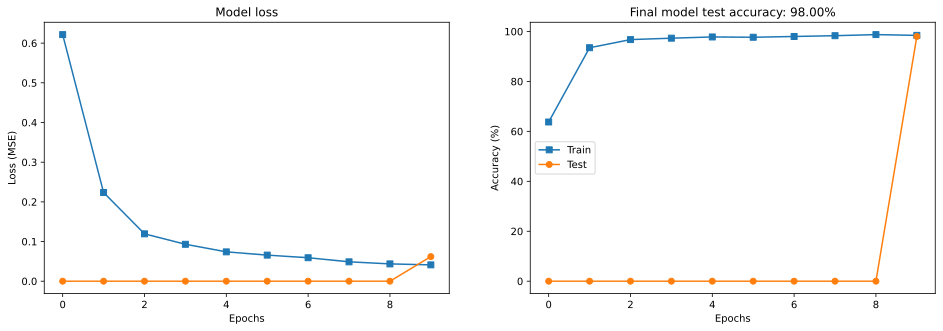

In [34]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

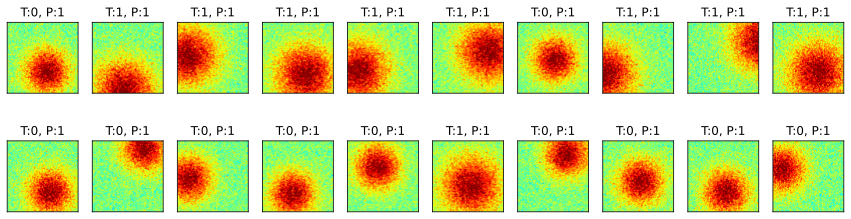

In [49]:
X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  G = G.cpu()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>0) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [53]:
print(net)

layer1W = net.enc[0].weight.cpu()
layer3W = net.enc[3].weight.cpu()

print(' ')
print(layer1W.shape)
print(layer3W.shape)

GausNet(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
 
torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])


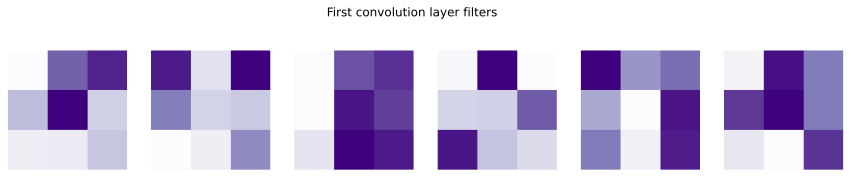

In [54]:
fig,axs = plt.subplots(1,6,figsize=(15,3))

for i,ax in enumerate(axs.flatten()):
  ax.imshow( torch.squeeze(layer1W[i,:,:,:]).detach() ,cmap='Purples')
  ax.axis('off')

plt.suptitle('First convolution layer filters')
plt.show()

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)


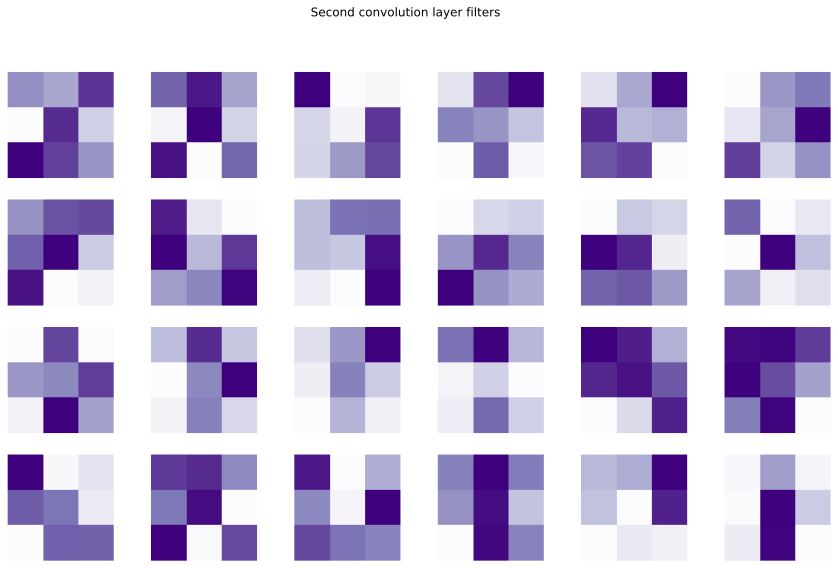

In [56]:
fig,axs = plt.subplots(4,6,figsize=(15,9))

for i in range(6*4):
  idx = np.unravel_index(i,(4,6))
  print(idx)
  axs[idx].imshow( torch.squeeze(layer3W[idx[0],idx[1],:,:]).detach() ,cmap='Purples')
  axs[idx].axis('off')

plt.suptitle('Second convolution layer filters')
plt.show()

In [58]:
np.unravel_index?

torch.Size([400, 1, 91, 91])


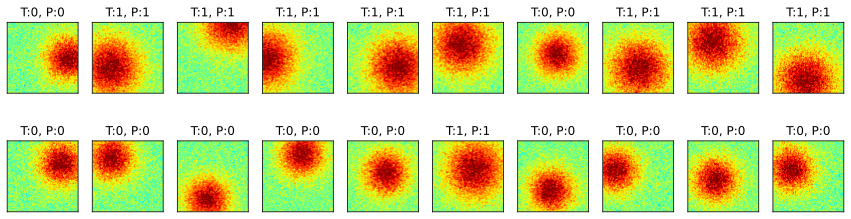

In [39]:
X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat,featmap1,featmap2 = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))
print(X.shape)
for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  G = G.cpu()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>.5) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

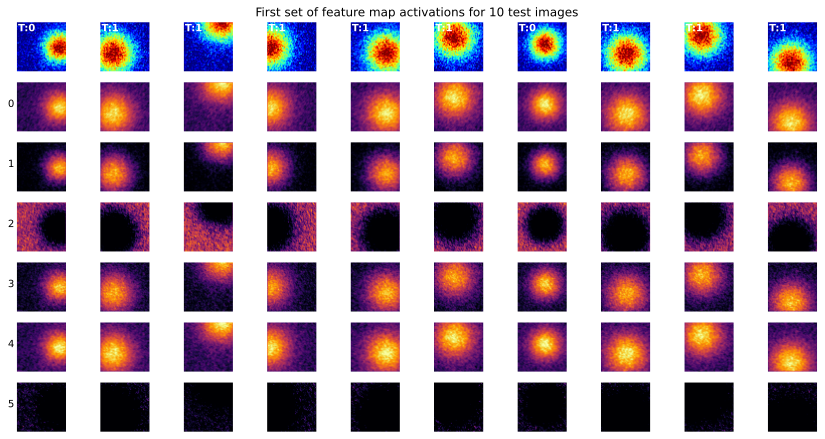

In [42]:
fig,axs = plt.subplots(7,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  img = img.cpu()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')
  axs[0,pici].text(2,2,'T:%s'%int(y[pici].item()),ha='left',va='top',color='w',fontweight='bold')

  for feati in range(6):
    # extract the feature map from this image
    img = featmap1[pici,feati,:,:].detach()
    img = img.cpu()
    axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
    axs[feati+1,pici].axis('off')
    axs[feati+1,pici].text(-5,45,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('First set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

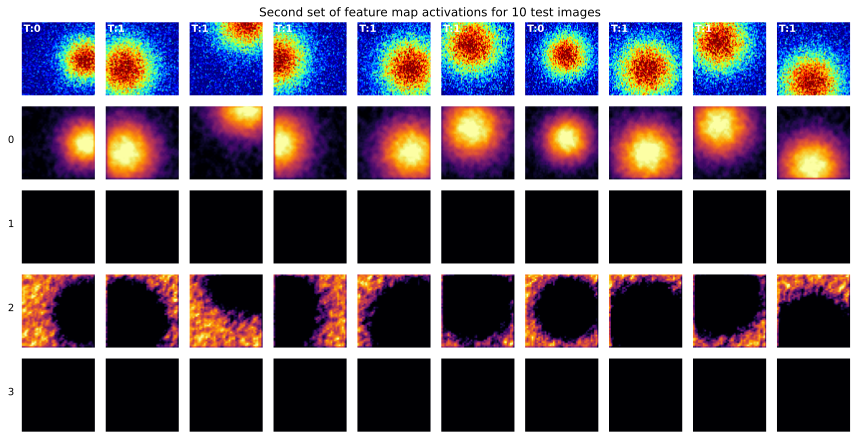

In [47]:
fig,axs = plt.subplots(5,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  img = img.cpu()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')
  axs[0,pici].text(2,2,'T:%s'%int(y[pici].item()),ha='left',va='top',color='w',fontweight='bold')

  for feati in range(4):
    # extract the feature map from this image
    img = featmap2[pici,feati,:,:].detach()
    img = img.cpu()
    axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
    axs[feati+1,pici].axis('off')
    axs[feati+1,pici].text(-5,22,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

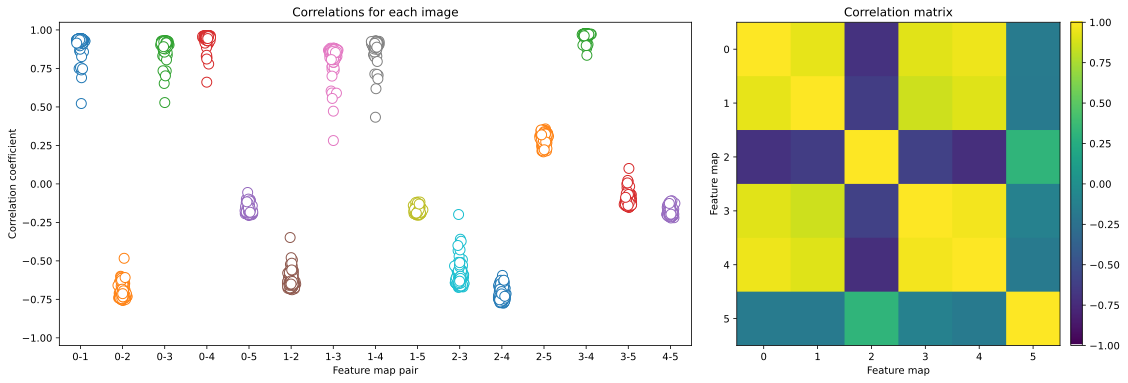

In [49]:
### correlations across the FIRST convolution layer

# convenient variables
nStim = featmap1.shape[0]
nMaps = featmap1.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap1[i,:,:,:].view(nMaps,-1).detach()
  featmaps = featmaps.cpu()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()